In [1]:
import numpy as np

import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from fsspec.implementations.local import LocalFileSystem

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.5494844.datarmor0/parcels-502090/libparcels_random_42940dad-2b33-4755-9a12-12d70cd4f95e.so


In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster() #processes=7, cores=7
w = cluster.scale(jobs=4)
#
client = Client(cluster)

In [3]:
client

Client Scheduler: tcp://10.148.0.236:36020 Dashboard: http://10.148.0.236:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [10]:
def binned_mean(df,dl):
    """Average dataframe over bins width dl
    
    Parameters 
    df : dataframe with at least longitude, latitude and field to bin in columns
    dl : bin width
    
    Returns
    df_mean : dataset with averaged fields
    """
    lon = np.arange(extent[0],extent[1], dl)
    lat = np.arange(extent[2], extent[3], dl)
    df['lon_cut'] = pd.cut(df['lon'], lon)
    df['lat_cut'] = pd.cut(df['lat'], lat)
    df_mean = df.groupby(['lon_cut','lat_cut']).mean()
    df_mean = pa.add_geodata(df_mean)
    df_mean = (df_mean
     #     .drop(columns=['Coordinates'])
          .set_index(['lon', 'lat'])
         .to_xarray()
        )
    return df_mean

In [4]:
ds = ut.load_data(["SSU","SSV"])

In [5]:
sli= 10
face = 7
grid = xr.open_zarr('/home1/datawork/xyu/grid/mit_grid.zarr')
ds = xr.merge([ds,grid]).isel(i_g=slice(0,None,sli),
                                      j_g=slice(0,None,sli),i=slice(0,None,sli),j=slice(0,None,sli))

In [6]:
ds = ds.sel(face=face).drop(['j_g','i_g']).rename({'j_g':'j','i_g':'i'})

In [7]:
ds['zonal_velocity'] =  ds['SSU']*ds.CS - ds['SSV']*ds.SN
ds['meridional_velocity'] =  ds['SSU']*ds.SN + ds['SSV']*ds.CS

In [8]:
ds = ds.compute()

In [11]:
zonal_velocity_mean = ds.zonal_velocity.mean('time')
meridional_velocity_mean = ds.meridional_velocity.mean('time')

In [12]:
SSU_mean = ds.SSU.mean('time')
SSV_mean = ds.SSV.mean('time')

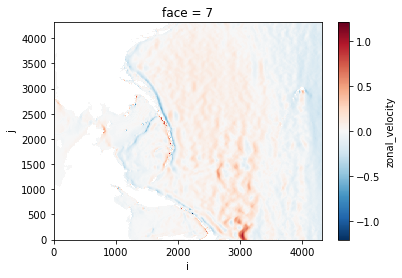

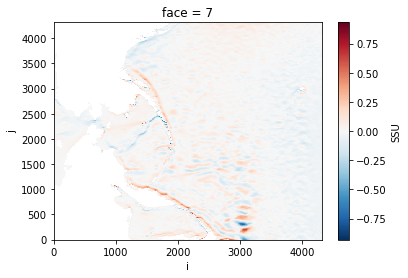

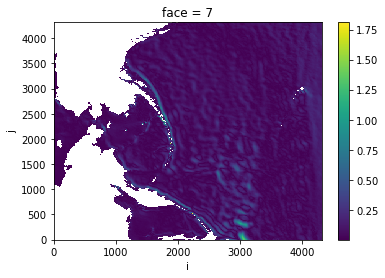

In [13]:
zonal_velocity_mean.plot()
plt.figure()
SSU_mean.plot()
plt.figure()
np.abs(zonal_velocity_mean-SSU_mean).plot()

In [14]:
ds['zonal_velocity_prime'] = ds.zonal_velocity-zonal_velocity_mean

In [15]:
ds['SSU_prime'] = ds.SSU-SSU_mean
ds['SSV_prime'] = ds.SSV-SSV_mean


In [36]:
#zona_var = (ds.zonal_velocity_prime**2).mean('time')#.plot()
#SSU_var = (ds.SSU_prime**2).mean('time')
#SSV_var = (ds.SSV_prime**2).mean('time')
SSU_var_rot =  SSU_var*ds.CS - SSV_var*ds.SN


In [38]:
#zona_var['lon'] = 0*zona_var.face+zona_var.XC
#zona_var['lat'] = 0*zona_var.face+zona_var.YC
#SSU_var['lon'] = 0*SSU_var.face+SSU_var.XC
#SSU_var['lat'] = 0*SSU_var.face+SSU_var.YC
SSU_var_rot['lon'] = 0*SSU_var_rot.face+SSU_var_rot.XC
SSU_var_rot['lat'] = 0*SSU_var_rot.face+SSU_var_rot.YC

In [19]:
zona_var = zona_var.drop([C for C in zona_var.coords][3:-2])
zona_var = zona_var.drop(['face'])
df_E = zona_var.to_dataframe()    

In [20]:
SSU_var = SSU_var.drop([C for C in SSU_var.coords][3:-2])
SSU_var = SSU_var.drop(['face'])
df_EU = SSU_var.to_dataframe()    

In [41]:
SSU_var_rot = SSU_var_rot.drop([C for C in SSU_var_rot.coords][4:])
#SSU_var_rot = SSU_var_rot.drop(['face'])
SSU_var_rot.name = 'SSU_prime_rot'
df_EU_rot = SSU_var_rot.to_dataframe()   

In [42]:
SSU_var_rot

<xarray.DataArray 'SSU_prime_rot' (j: 432, i: 432)>
array([[       nan,        nan,        nan, ..., 0.03251327, 0.02794864,
        0.02462789],
       [       nan,        nan,        nan, ..., 0.0412425 , 0.03614565,
        0.02585006],
       [       nan,        nan,        nan, ..., 0.04567662, 0.03479569,
        0.02578884],
       ...,
       [       nan,        nan,        nan, ..., 0.01602738, 0.01742327,
        0.01842559],
       [       nan,        nan,        nan, ..., 0.01737994, 0.01910333,
        0.02003669],
       [       nan,        nan,        nan, ..., 0.02096285, 0.02008892,
        0.02114871]], dtype=float32)
Coordinates:
  * j        (j) int64 0 10 20 30 40 50 60 ... 4260 4270 4280 4290 4300 4310
  * i        (i) int64 0 10 20 30 40 50 60 ... 4260 4270 4280 4290 4300 4310
    lon      (j, i) float64 142.0 142.0 142.0 142.0 ... -128.2 -128.2 -128.2
    lat      (j, i) float64 67.5 67.49 67.47 67.45 ... 14.47 14.29 14.1 13.91

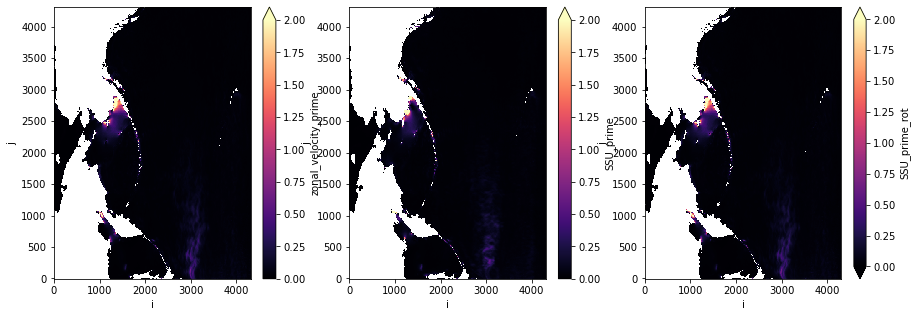

In [28]:
cmap='magma'
fig,ax = plt.subplots(1,3,figsize=(15,5))
zona_var.plot(ax=ax[0],vmax=2,vmin=0,cmap=cmap)
SSU_var.plot(ax=ax[1],vmax=2,vmin=0,cmap=cmap)
SSU_var_rot.plot(ax=ax[2],vmax=2,vmin=0,cmap=cmap)

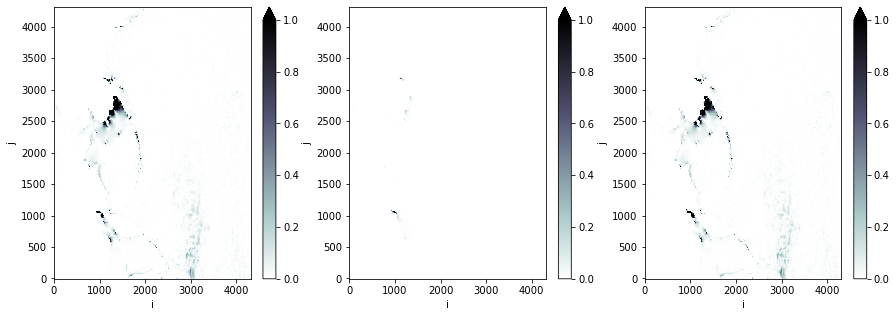

In [29]:
cmap='bone_r'
fig,ax = plt.subplots(1,3,figsize=(15,5))
np.abs(zona_var-SSU_var).plot(ax=ax[0],vmax=1,vmin=0,cmap=cmap)
np.abs(zona_var-SSU_var_rot).plot(ax=ax[1],vmax=1,vmin=0,cmap=cmap)
np.abs(SSU_var-SSU_var_rot).plot(ax=ax[2],vmax=1,vmin=0,cmap=cmap)

In [30]:
llc_lon, llc_lat = ds.XC.compute(), ds.YC.compute()
extent = [float(llc_lon.min()), float(llc_lon.max()), 
          float(llc_lat.min()), float(llc_lat.max()),
         ]
extent

[-179.99798583984375,
 179.99949645996094,
 13.914505958557129,
 72.03907775878906]

In [31]:
dl = 1.
ds_Estats = binned_mean(df_E,dl)
ds_Estats

<xarray.Dataset>
Dimensions:               (lat: 58, lon: 359)
Coordinates:
  * lon                   (lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5
  * lat                   (lat) float64 14.41 15.41 16.41 ... 69.42 70.42 71.42
Data variables:
    zonal_velocity_prime  (lon, lat) float32 0.02035 0.01513 ... 0.005612

In [32]:
ds_EstatsU = binned_mean(df_EU,dl)
ds_EstatsU

<xarray.Dataset>
Dimensions:    (lat: 58, lon: 359)
Coordinates:
  * lon        (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 176.5 177.5 178.5
  * lat        (lat) float64 14.41 15.41 16.41 17.41 ... 68.42 69.42 70.42 71.42
Data variables:
    SSU_prime  (lon, lat) float32 0.01459 0.0194 0.01974 ... 0.009103 0.00982

In [35]:
SSU_var_rot

<xarray.DataArray 'SSU_prime_rot' (j: 432, i: 432)>
array([[       nan,        nan,        nan, ..., 0.03251327, 0.02794864,
        0.02462789],
       [       nan,        nan,        nan, ..., 0.0412425 , 0.03614565,
        0.02585006],
       [       nan,        nan,        nan, ..., 0.04567662, 0.03479569,
        0.02578884],
       ...,
       [       nan,        nan,        nan, ..., 0.01602738, 0.01742327,
        0.01842559],
       [       nan,        nan,        nan, ..., 0.01737994, 0.01910333,
        0.02003669],
       [       nan,        nan,        nan, ..., 0.02096285, 0.02008892,
        0.02114871]], dtype=float32)
Coordinates:
  * j        (j) int64 0 10 20 30 40 50 60 ... 4260 4270 4280 4290 4300 4310
  * i        (i) int64 0 10 20 30 40 50 60 ... 4260 4270 4280 4290 4300 4310
    CS       (j, i) float32 0.0 0.0 0.0 0.0 0.0 ... -0.0 -0.0 -0.0 -4.392e-14

In [43]:
ds_EstatsU_rot = binned_mean(df_EU_rot,dl)
ds_EstatsU_rot

<xarray.Dataset>
Dimensions:        (lat: 58, lon: 359)
Coordinates:
  * lon            (lon) float64 -179.5 -178.5 -177.5 ... 176.5 177.5 178.5
  * lat            (lat) float64 14.41 15.41 16.41 17.41 ... 69.42 70.42 71.42
Data variables:
    SSU_prime_rot  (lon, lat) float32 0.02035 0.01513 ... 0.007858 0.007279

In [44]:
ds_Estats["SSU_prime"]=ds_EstatsU.SSU_prime
ds_Estats["SSU_prime_rot"]=ds_EstatsU_rot.SSU_prime_rot

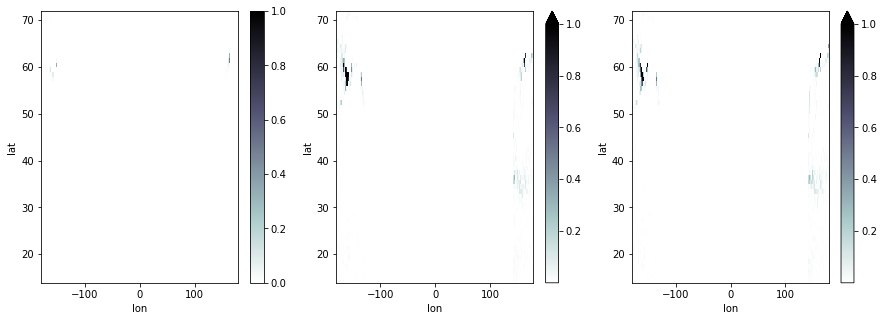

In [47]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
np.abs(ds_Estats['zonal_velocity_prime']-ds_Estats['SSU_prime_rot']).plot(y='lat',ax=ax[0],vmax=1,cmap='bone_r')
np.abs(ds_Estats['zonal_velocity_prime']-ds_Estats['SSU_prime']).plot(y='lat',ax=ax[1],vmax=1,cmap='bone_r')
np.abs(ds_Estats['SSU_prime']-ds_Estats['SSU_prime_rot']).plot(y='lat',ax=ax[2],vmax=1,cmap='bone_r')

In [48]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
